In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Laboratorio #3 - (RNN para Forecasting de Demanda)

### ***Carga de libreriras y Dataset***

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
data_path = '/content/drive/MyDrive/03 Statistical Learning II/04 Laboratorio #3 - (RNN para Forecasting de Demanda)/train.csv'
df = pd.read_csv(data_path, encoding='latin-1', header=0, parse_dates=['date'])
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
df.isnull().values.any()

False

In [7]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [8]:
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

### ***Fraccion de Dataset 80% Training y 20% Testing***

In [9]:
X = df.values
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))


Observations: 913000
Training Observations: 730400
Testing Observations: 182600


In [10]:
col = ['date','store','item','sales' ]

In [11]:
train = pd.DataFrame(train, columns = col)
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
730395,2017-12-27,10,40,34
730396,2017-12-28,10,40,30
730397,2017-12-29,10,40,33
730398,2017-12-30,10,40,29


### ***Extraccion de dia, mes, año y semana***

In [12]:
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

train_df = expand_df(train)
display(train)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
730395,2017-12-27,10,40,34
730396,2017-12-28,10,40,30
730397,2017-12-29,10,40,33
730398,2017-12-30,10,40,29


In [13]:
train_df = train_df.set_index('date')
train_df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


In [14]:
train_df['year'].value_counts()[:6]

2016    146400
2013    146000
2014    146000
2015    146000
2017    146000
Name: year, dtype: int64

### Se tomo el año 2017 para el analisis debido a la cantidad de datos para el Forcasting

In [15]:
Year_17 = train_df['year'] == 2017

In [16]:
train_df_17 = train_df[Year_17]

In [17]:
train_df_17.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2017-01-01,1,1,19,1,1,2017,6
2017-01-02,1,1,15,2,1,2017,0
2017-01-03,1,1,10,3,1,2017,1
2017-01-04,1,1,16,4,1,2017,2
2017-01-05,1,1,14,5,1,2017,3


## **Test**

In [18]:
col = ['date','store','item','sales' ]

In [19]:
test = pd.DataFrame(test, columns = col)
test


,date,store,item,sales
0,2013-01-01,1,41,6
1,2013-01-02,1,41,15
2,2013-01-03,1,41,5
3,2013-01-04,1,41,9
4,2013-01-05,1,41,13
...,...,...,...,...
182595,2017-12-27,10,50,63
182596,2017-12-28,10,50,59
182597,2017-12-29,10,50,74
182598,2017-12-30,10,50,62


In [20]:
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

In [21]:
test_df = expand_df(test)
display(test)

,date,store,item,sales
0,2013-01-01,1,41,6
1,2013-01-02,1,41,15
2,2013-01-03,1,41,5
3,2013-01-04,1,41,9
4,2013-01-05,1,41,13
...,...,...,...,...
182595,2017-12-27,10,50,63
182596,2017-12-28,10,50,59
182597,2017-12-29,10,50,74
182598,2017-12-30,10,50,62


In [22]:
test_df = test_df.set_index('date')
test_df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,41,6,1,1,2013,1
2013-01-02,1,41,15,2,1,2013,2
2013-01-03,1,41,5,3,1,2013,3
2013-01-04,1,41,9,4,1,2013,4
2013-01-05,1,41,13,5,1,2013,5


In [23]:
test_df['year'].value_counts()[:6]

2016    36600
2013    36500
2014    36500
2015    36500
2017    36500
Name: year, dtype: int64

In [24]:
Year_17 = test_df['year'] == 2017

In [25]:
test_df_17 = test_df[Year_17]

In [26]:
test_df_17.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2017-01-01,1,41,30,1,1,2017,6
2017-01-02,1,41,19,2,1,2017,0
2017-01-03,1,41,11,3,1,2017,1
2017-01-04,1,41,18,4,1,2017,2
2017-01-05,1,41,15,5,1,2017,3


In [27]:
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

### ***Graficas para la evaluacion de store por item***

#### Del total de 10 store y 50 item se presenta el ejmplo de 1 store y 1 item para la presentacion grafica.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


<Figure size 432x288 with 0 Axes>

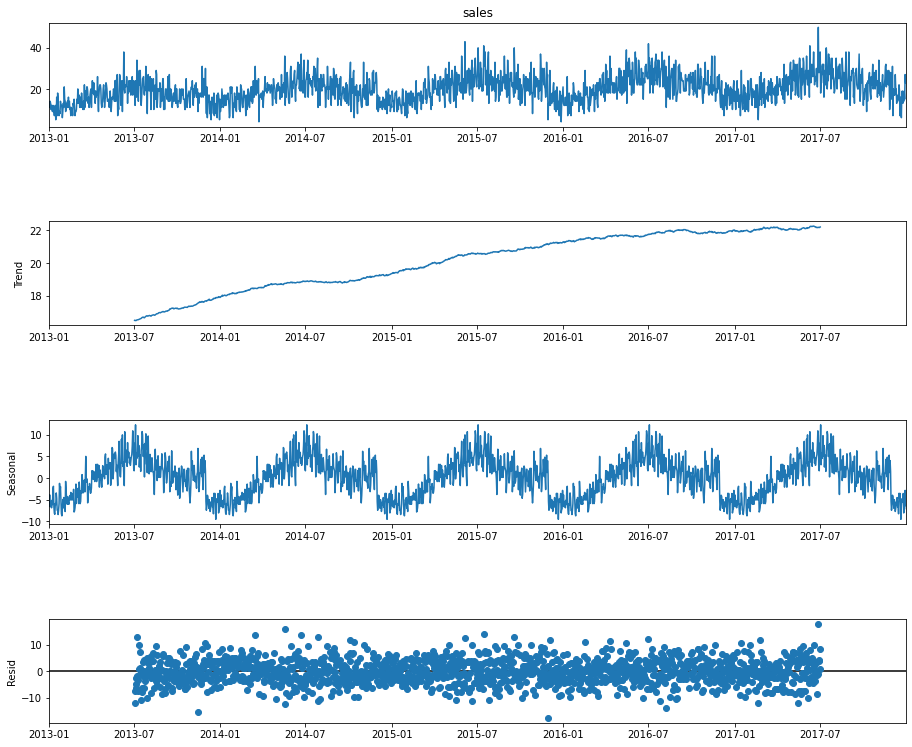

In [28]:
train_item1 = train_df[train_df['item']==1]
train_final = train_item1[train_item1['store']==1]

#from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(train_final['sales'], model='additive', freq=365) #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

## **Evaluacion RNN con dataset igual año 2017**

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
dataTrain_scaled = scaler.fit_transform(train_df_17)

### Se aplica una ventana de 30 dias tomando mes comercial para la evaluacion

In [30]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = dataTrain_scaled.shape[0]
ventana = 30
for i in range(ventana, cantidad):
  X_train.append(dataTrain_scaled[i - ventana: i, 0])
  Y_train.append(dataTrain_scaled[i, 0])

In [31]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [33]:
X_train

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

In [34]:
X_train.shape

(145970, 30, 1)

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

**Capas de RNN**

In [36]:
forecaster = Sequential()

#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=5, return_sequences=True))

#capa2
forecaster.add(LSTM(units=3, return_sequences=True))

#capa3
forecaster.add(LSTM(units=2, return_sequences=True))

#capa4 
forecaster.add(LSTM(units=5, return_sequences=False))

#capa de salida
forecaster.add(Dense(units=5, activation='relu'))

**Parametros de Optimizacion**

In [37]:
forecaster.compile(optimizer='adam', loss='mean_squared_error')

**Parametros de Entrenamiento**

In [ ]:
forecaster.fit(X_train, y_train, epochs=25, batch_size=256)

Epoch 1/25
571/571 [==============================] - 48s 85ms/step - loss: 3.1696e-04
Epoch 2/25
571/571 [==============================] - 48s 83ms/step - loss: 3.1441e-04
Epoch 3/25
571/571 [==============================] - 32s 57ms/step - loss: 3.1624e-04
Epoch 4/25
571/571 [==============================] - 32s 55ms/step - loss: 3.1398e-04
Epoch 5/25
571/571 [==============================] - 35s 62ms/step - loss: 3.1214e-04
Epoch 6/25
571/571 [==============================] - 32s 56ms/step - loss: 3.1403e-04
Epoch 7/25
571/571 [==============================] - 33s 57ms/step - loss: 3.1131e-04
Epoch 8/25
571/571 [==============================] - 33s 58ms/step - loss: 3.1111e-04
Epoch 9/25
189/571 [========>.....................] - ETA: 21s - loss: 3.5881e-04

**Descarga de dataset con la prediccion de Forcasting**

In [62]:
forecaster.save('/content/drive/MyDrive/03 Statistical Learning II/04 Laboratorio #3 - (RNN para Forecasting de Demanda)/RNN_v1.h5')

In [63]:
test_df_17.head(5)

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2017-01-01,1,41,30,1,1,2017,6
2017-01-02,1,41,19,2,1,2017,0
2017-01-03,1,41,11,3,1,2017,1
2017-01-04,1,41,18,4,1,2017,2
2017-01-05,1,41,15,5,1,2017,3


In [64]:
real_test_sales = test_df_17.iloc[:, 2:3].values
real_test_sales

array([[30],
       [19],
       [11],
       ...,
       [74],
       [62],
       [82]], dtype=object)

**Union de dataset test y train**

In [65]:
dataset_total = pd.concat((train_df_17['sales'], test_df_17['sales']), axis=0)
dataset_total

date
2017-01-01    19
2017-01-02    15
2017-01-03    10
2017-01-04    16
2017-01-05    14
              ..
2017-12-27    63
2017-12-28    59
2017-12-29    74
2017-12-30    62
2017-12-31    82
Name: sales, Length: 182500, dtype: object

In [66]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [67]:
input_test = dataset_total[len(dataset_total) - len(test_df_17) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.fit_transform(input_test)
input_test

array([[0.10891089],
       [0.18316832],
       [0.08910891],
       ...,
       [0.35148515],
       [0.29207921],
       [0.39108911]])

In [68]:
cantidad_final = len(input_test)
cantidad_final

36530

In [69]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [70]:
X_test.shape

(36500, 30)

In [71]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [72]:
X_test.shape

(36500, 30, 1)

# **Prediccion Forcast**

In [73]:
predicciones_rnn = forecaster.predict(X_test)
predicciones_rnn

array([[0.12934265, 0.12921667, 0.13051037, 0.12937546, 0.129677  ],
       [0.13427198, 0.13463387, 0.13451472, 0.13452947, 0.13446979],
       [0.09347182, 0.09154792, 0.09654009, 0.0932368 , 0.09437825],
       ...,
       [0.27291554, 0.270475  , 0.27162993, 0.27231932, 0.27403775],
       [0.34954137, 0.35208338, 0.34369135, 0.35028386, 0.3484578 ],
       [0.29985747, 0.2968292 , 0.30470815, 0.29781604, 0.30072808]],
      dtype=float32)

In [74]:
predicciones_rnn.shape

(36500, 5)

In [75]:
#invertimos noramalizacion
real_predicted_sales = scaler.inverse_transform(predicciones_rnn)
real_predicted_sales

array([[29.127213, 29.101767, 29.363094, 29.133842, 29.194752],
       [30.122938, 30.196041, 30.171972, 30.174952, 30.162897],
       [21.881308, 21.492682, 22.501099, 21.833836, 22.064407],
       ...,
       [58.128937, 57.63595 , 57.869244, 58.008503, 58.355625],
       [73.60735 , 74.12084 , 72.42565 , 73.75734 , 73.38848 ],
       [63.57121 , 62.959496, 64.55105 , 63.15884 , 63.74707 ]],
      dtype=float32)

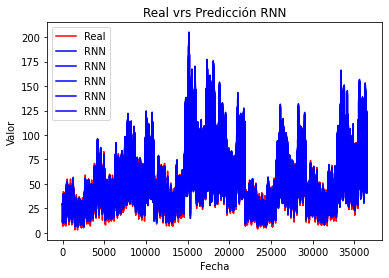

In [76]:
plt.plot(real_test_sales, color="red", label="Real")
plt.plot(real_predicted_sales, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

In [77]:
!pip install pyramid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Graficas de descomposición de PACF Y ACF**

In [78]:
#from pyramid.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

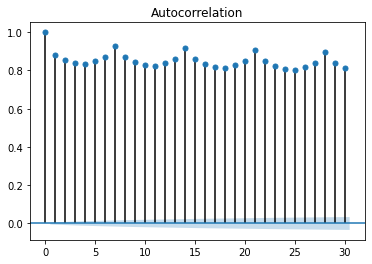

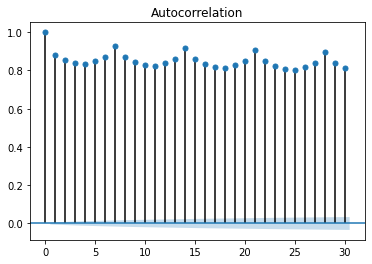

In [79]:
plot_acf(train_df_17['sales'], lags=30)

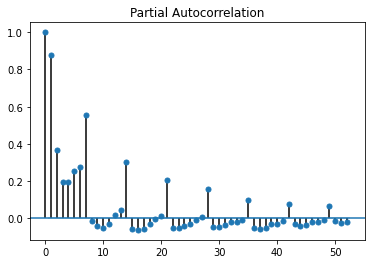

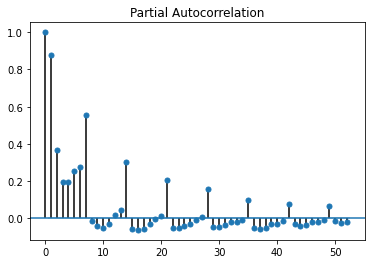

In [80]:
plot_pacf(train_df_17['sales'])

***SMAPE***

### El resultado inicial fue de un SMAPE de 220, Se efecutuaron algunas modificaciones en la RNN y se logro alcanzar un SMAPE de 106 como mejor resultado de las pruebas.

In [81]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [82]:
smape(real_test_sales, real_predicted_sales)

106.64937873882637